<a href="https://colab.research.google.com/github/DJCordhose/ml-workshop/blob/master/notebooks/tf2/time-series-encoder-decoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Forecasting Time Series data: Encoder / Decoder Approach

* Nice tutorial: https://www.tensorflow.org/beta/tutorials/text/time_series

In [0]:
import pandas as pd
import numpy as np

In [0]:
%matplotlib inline

import matplotlib.pyplot as plt
# plt.xkcd()
# plt.style.use('ggplot')
%matplotlib inline

import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (20, 8)

In [0]:
# for local
# url = 'opsd_germany_daily.csv'

# for colab
url = 'https://raw.githubusercontent.com/jenfly/opsd/master/opsd_germany_daily.csv'

time_series_df = pd.read_csv(url, 
                             sep=',', 
                             index_col=0, # you can use the date as the index for pandas
                             parse_dates=[0]) # where is the time stamp?

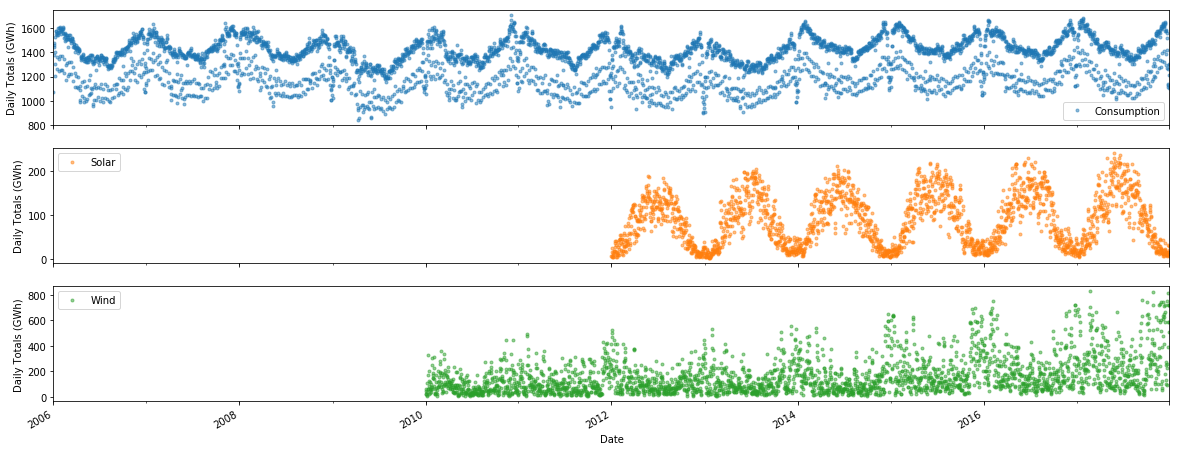

In [4]:
cols_plot = ['Consumption', 'Solar', 'Wind']

axes = time_series_df[cols_plot].plot(marker='.', alpha=0.5, linestyle='None', subplots=True)
for ax in axes:
    ax.set_ylabel('Daily Totals (GWh)')

## Encoder / Decoder

* Encode input using RNNs
* Store into latent representation
* Decode using RNNs again
* Use one neuron at the end to combine to a sequence of single values 

In [5]:
days_2016_2017 = time_series_df['2016': '2017']['Consumption'].to_numpy()
days_2016_2017.shape

(731,)

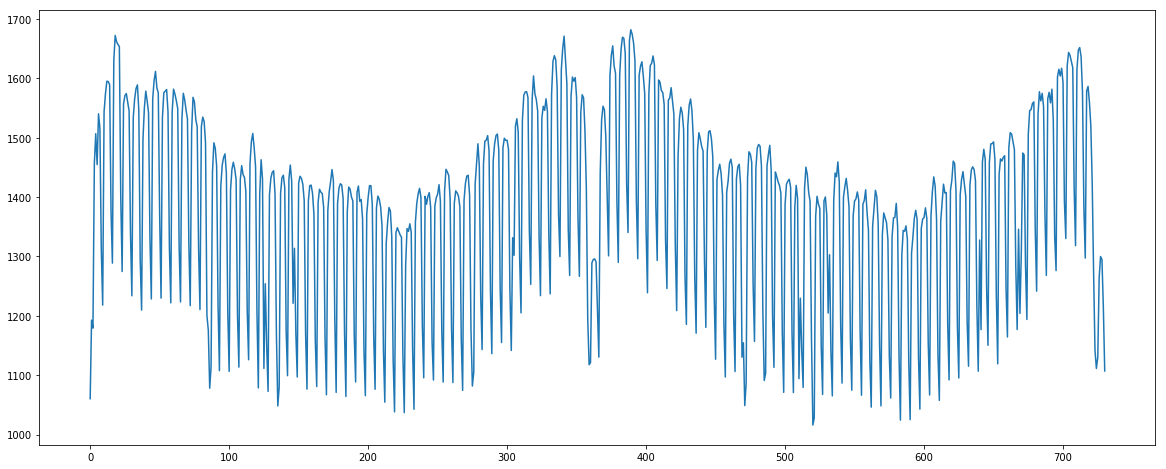

In [6]:
plt.plot(days_2016_2017);

In [0]:
# derived from here: https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return np.array(X), np.array(y)

In [0]:
#@title Prediction from n days to m days

n_steps_in = 30 #@param {type:"slider", min:1, max:100, step:1}
n_steps_out = 30 #@param {type:"slider", min:1, max:100, step:1}

In [9]:
X, Y = split_sequence(days_2016_2017, n_steps_in, n_steps_out)
X.shape, Y.shape

((672, 30), (672, 30))

In [10]:
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
Y = Y.reshape((Y.shape[0], Y.shape[1], n_features))
X.shape, Y.shape

((672, 30, 1), (672, 30, 1))

In [11]:
# Gives us a well defined version of tensorflow

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [12]:
import tensorflow as tf
print(tf.__version__)

2.0.0-rc1


In [0]:
# adapted from https://stackoverflow.com/a/42351397/1756489 and ported to TF 2
# https://keras.io/metrics/#custom-metrics

def r2_metric(y_true, y_pred):
  total_error = tf.reduce_sum(tf.square(tf.subtract(y_true, tf.reduce_mean(y_true))))
  unexplained_error = tf.reduce_sum(tf.square(tf.subtract(y_true, y_pred)))
  R_squared = tf.subtract(1.0, tf.divide(unexplained_error, total_error))
  
  return R_squared

In [14]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Bidirectional
from tensorflow.keras.models import Sequential, Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import RepeatVector, Input

ENCODER_SIZE = 128
DECODER_SIZE = 128

ENCODING_DIM = 256

model = Sequential()

# ENCODER

model.add(Input(shape=(n_steps_in, n_features), name='Input'))


# model.add(LSTM(units=ENCODER_SIZE, activation='relu', name="encode1r", return_sequences=True))
model.add(LSTM(units=ENCODER_SIZE, activation='relu', name="encoder2"))


# LATENT SPACE

model.add(Dense(units=ENCODING_DIM, activation='relu', name="latent_space1"))
model.add(Dense(units=ENCODING_DIM, activation='relu', name="latent_space2"))

# DECODER

model.add(RepeatVector(n_steps_out))

# return_sequences=True tells it to keep all temporal outputs, not only the final one (we need all of them for our predicted sequence)
model.add(LSTM(units=DECODER_SIZE, activation='relu', return_sequences=True, name="decoder"))

model.add(Dense(units=1))
optimizer = Adam(lr=1e-3)
model.compile(optimizer=optimizer, loss='mse', metrics=[r2_metric])
# model.compile(optimizer='adam', loss='mae')

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder2 (LSTM)              (None, 128)               66560     
_________________________________________________________________
latent_space1 (Dense)        (None, 256)               33024     
_________________________________________________________________
latent_space2 (Dense)        (None, 256)               65792     
_________________________________________________________________
repeat_vector (RepeatVector) (None, 30, 256)           0         
_________________________________________________________________
decoder (LSTM)               (None, 30, 128)           197120    
_________________________________________________________________
dense (Dense)                (None, 30, 1)             129       
Total params: 362,625
Trainable params: 362,625
Non-trainable params: 0
__________________________________________________

CPU times: user 11min 46s, sys: 1min 9s, total: 12min 56s
Wall time: 8min 21s


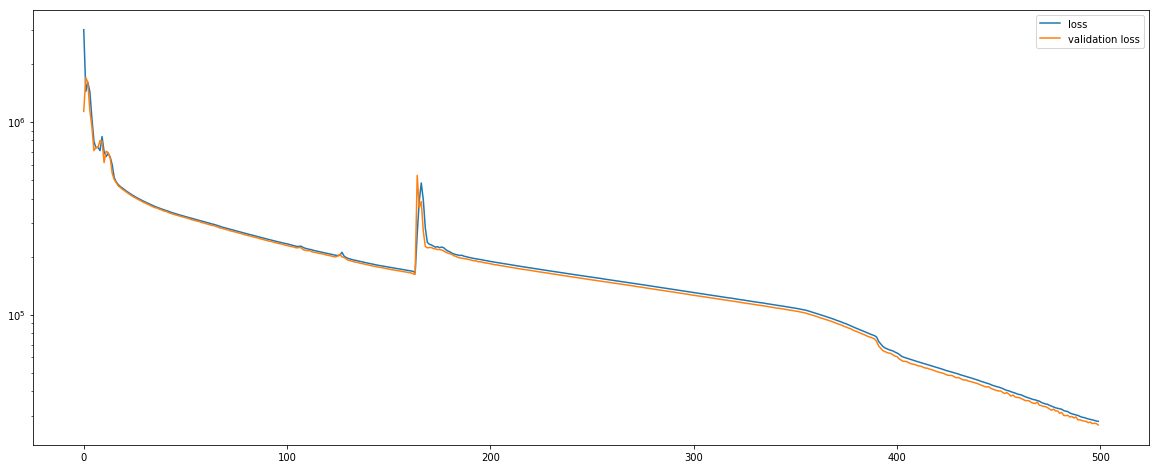

In [15]:
%%time

EPOCHS = 500
BATCH_SIZE = 50

history = model.fit(X, Y, epochs=EPOCHS, batch_size=BATCH_SIZE, verbose=0, validation_split=0.2)

plt.yscale('log')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'validation loss'])

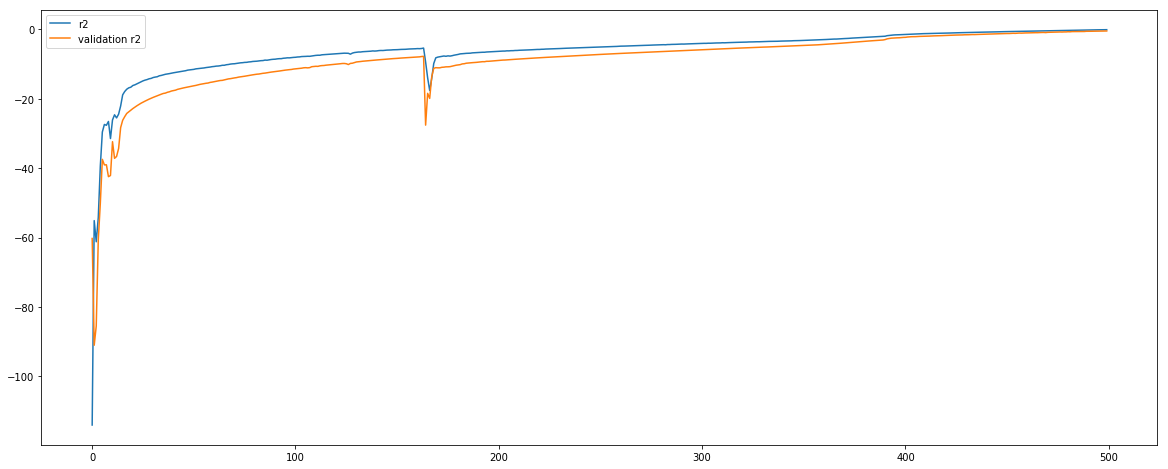

In [16]:
# plt.yscale('log')
plt.plot(history.history['r2_metric'])
plt.plot(history.history['val_r2_metric'])
plt.title('R^2 over Epochs')

plt.legend(['r2', 'validation r2'])

In [0]:
final_week_2017 = X[-1]
# final_week_2017

In [18]:
first_week_2018 = model.predict(final_week_2017.reshape(1, -1, 1))
first_week_2018

array([[[1218.1908],
        [1536.9072],
        [1559.3181],
        [1512.6206],
        [1610.2562],
        [1495.0864],
        [1557.2465],
        [1518.5978],
        [1545.76  ],
        [1509.4546],
        [1517.995 ],
        [1522.4954],
        [1503.6938],
        [1463.2898],
        [1647.0237],
        [1520.7395],
        [1495.6128],
        [1461.2908],
        [1507.9799],
        [1492.3232],
        [1483.5695],
        [1500.5835],
        [1534.1083],
        [1548.621 ],
        [1529.8552],
        [1492.0308],
        [1494.9205],
        [1505.6768],
        [1456.2877],
        [1538.4075]]], dtype=float32)

### Results are not bad, but funky at their ends

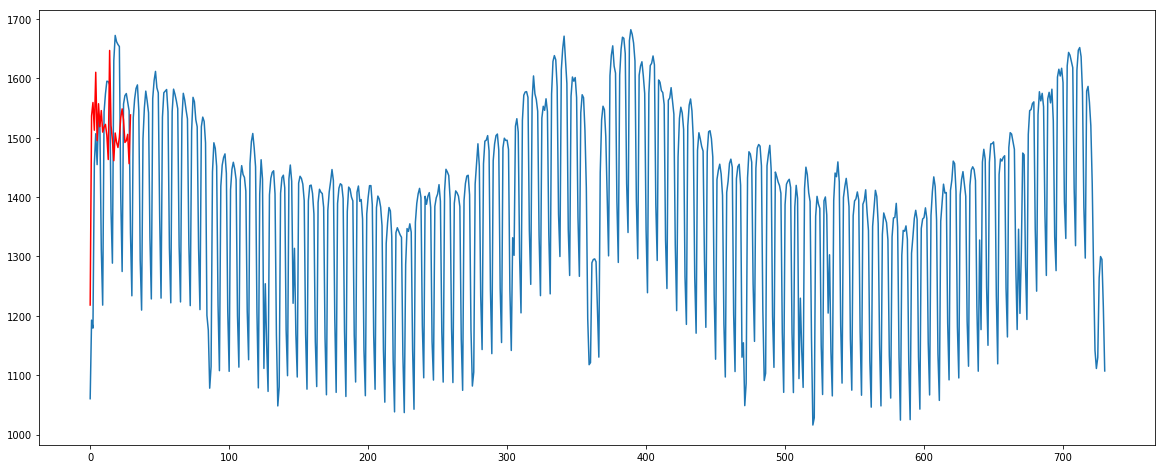

In [19]:
plt.plot(days_2016_2017)
plt.plot(first_week_2018[0], color='r');

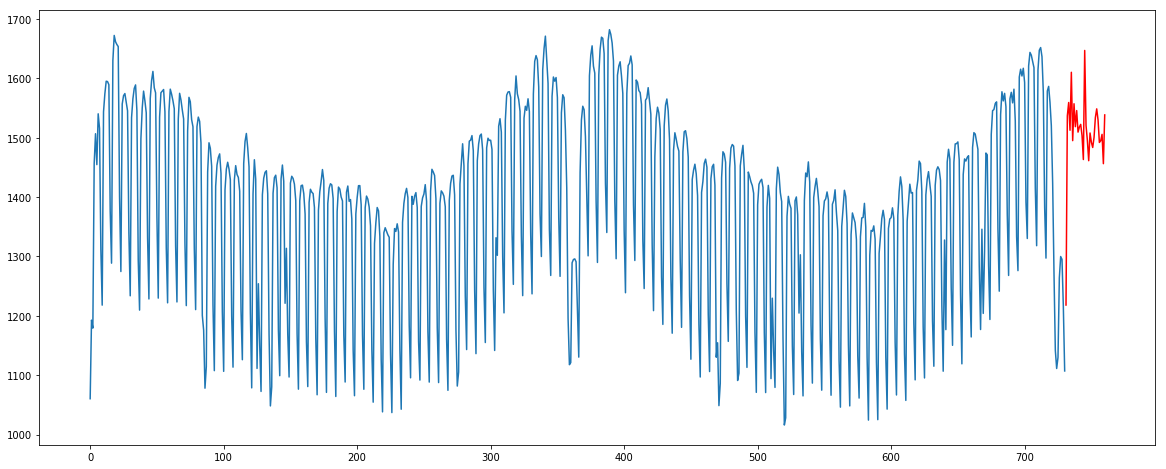

In [20]:
known_x = np.arange(len(days_2016_2017))
pred_x = np.arange(len(days_2016_2017), len(days_2016_2017) + n_steps_out)

plt.plot(known_x, days_2016_2017)
plt.plot(pred_x, first_week_2018[0], color='r');